# bio

> This module include general tools useful accross many tasks related to biology

In [ ]:
#| default_exp bio

In [ ]:
#| hide
from __future__ import annotations
from ecutils.ipython import nb_setup, files_in_tree
import nbdev

In [ ]:
#| hide
nb_setup()

Set autoreload mode


In [ ]:
#| hide
import json
import pandas as pd
import re
import urllib
import urllib
from itertools import chain
from pathlib import Path, PurePath
from typing import Generator, Tuple, Union

# File structure for the project

## Sequence Files

All sequence are available as FASTA files.

FASTA files count two lines for each sequence (see reference on [NCBI site](https://www.ncbi.nlm.nih.gov/genbank/fastaformat/) and [wikipedia](https://en.wikipedia.org/wiki/FASTA_format):
- the fasta definition line starting with `>` and a `SeqID`: `>2591237`. After that format varies.
- the sequence line, following the metadata line: `TATTAGGTTTTCTACCTACCCAGGAAAAGCCAACCA ...`

**FASTA Format for Nucleotide Sequences** (from NCBI reference)

In FASTA format the line before the nucleotide sequence, called the FASTA definition line, must begin with a carat (`>`), followed by a unique `SeqID` (sequence identifier).

The `SeqID` must be unique for each nucleotide sequence and should not contain any spaces. Please limit the SeqID to 25 characters or less. ...

> example: `›SeqABCD`; `>2591237`

Example of corona virus sequence files (fasta) with different number of sequences:
```
data
  |--cov_data
  |    |--cov_virus_sequences_hundred.fa
  |    |--cov_virus_sequence_one_2.fa
  |    |--cov_virus_sequences_two.fa
  |    |--cov_virus_sequences_twenty_five.fa
  |    |--cov_virus_sequences_ten.fa
  |    |--cov_virus_sequence_one_1.fa
  |    |--cov_virus_sequences.fa
```

The fasta files used in this project have the following structure:
```
>2591237:ncbi:1 [MK211378]	2591237	ncbi	1 [MK211378] 2591237	Coronavirus BtRs-BetaCoV/YN2018D	scient
TATTAGGTTTTCTACCTACCCAGGAAAAGCCAACCAACCTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTAGCTGTCGCTCGGCTGCATGCCTA ...
>11128:ncbi:2 [LC494191]
CATCCCGCTTCACTGATCTCTTGTTAGATCTTTTCATAATCTAAACTTTATAAAAACATCCACTCCCTGTAGTCTATGCCTATGGGCGTAGATTTTTCATAGTGGTGTCT ...
>31631:ncbi:3 [KY967361]	31631	ncbi	3 [KY967361] 31631	Human coronavirus OC43	scientific name
ATCTCTTGTTAGATCTTTTTGTAATCTAAACTTTATAAAAACATCCACTCCCTGTAATCTATGCTTGTGGGCGTAGATTTTTCATAGTGGTGTTTATATTCATTTCTGCT ...
>277944:ncbi:4 [LC654455]	277944	ncbi	4 [LC654455] 277944	Human coronavirus NL63	scientific name
ATTTTCTTATTTAGACTTTGTGTCTACTCTTCTCAACTAAACGAAATTTTTCTAGTGCTGTCATTTGTTATGGCAGTCCTAGTGTAATTGAAATTTCGTCAAGTTTGTAA ...
>11120:ncbi:5 [MN987231]	11120	ncbi	5 [MN987231] 11120	Infectious bronchitis virus	scientific name
TCCTAAGTGTGATATAAATATATATCATACACACTAGCCTTGCGCTAGATTTCTAACTTAACAAAACGGACTTAAATACCTACAGCTGGTCCCTATAGGTGTTCCATTGC ...
>28295:ncbi:6 [KU893866]	28295	ncbi	6 [KU893866] 28295	Porcine epidemic diarrhea virus	scientific name
ACTTAAAGAGATTTTCTATCTACGGATAGTTAGCTCTTTTTCTAGACTCTTGTCTACTCAATTCAACTAAACGAAATTTTGTCCTTCCGGCCGCATGTCCATGCTGCTGG ...
>28295:ncbi:7 [KJ645638]	28295	ncbi	7 [KJ645638] 28295	Porcine epidemic diarrhea virus	scientific name
CTTTTTCTAGACTCTTGTCTACTCAATTCAACTAAACGAAATTTTGTCCTTCCGGCCGCATGTCCATGCTGCTGGAAGCTGACGTGGAATTTCATTAGGTTTGCTTAAGT ...
>28295:ncbi:8 [KJ645678]	28295	ncbi	8 [KJ645678] 28295	Porcine epidemic diarrhea virus	scientific name
CTTTTTCTAGACTCTTGTCTACTCAATTCAACTAAACGAAATTTTGTCCTTCCGGCCGCATGTCCATGCTGCTGGAAGCTGACGTGGAATTTCATTAGGTTTGCTTAAGT ...
>28295:ncbi:9 [KR873434]	28295	ncbi	9 [KR873434] 28295	Porcine epidemic diarrhea virus	scientific name
ACTTAAAGAGATTTTCTATCTACGGATAGTTAGCTCTTTTTCTAGACTCTTGTCTACTCAATTCAACTAAACGAAATTTTGTCCTTCCGGCCGCATGTCCATGCTGCTGG ...
>1699095:ncbi:10 [KT368904]	1699095	ncbi	10 [KT368904] 1699095	Camel alphacoronavirus		scientific name
ACTTAAGTGTCTTATCTATCTATAGATAGAAAAGTCGCTTTTTAGACTTTGTGTCTACTCTTCTCAACTAAACGAAATTTTTGCTACGGCCGGCATCTCTGATGCTGGAG ...
```

In this format, the *Definition Lines* includes the following metadata:
- **SeqID**, e.g. `2591237`

- **source** of the sequence, all from `ncbi`

- **seq_nbr**, that is the position of the sequence in the file, e.g. `1`

- **accession**, e.g. `MK211378`

- **species**, e.g. `Coronavirus BtRs-BetaCoV/YN2018D`. 

```ascii
>2591237:ncbi:1 [MK211378]	2591237	ncbi	1 [MK211378] 2591237	Coronavirus BtRs-BetaCoV/YN2018D		scientific name
```

The **species** is missing for some of the sequences, like for the sequence with SeqID `11128`


```ascii
>11128:ncbi:2 [LC494191]
```

## Simulated Read Files

The simulated reads are sequences of a fixed length (e.g. 50 bp or 150 bp) or within a length range. They also include a line with quality information and are saved in **FASTQ** format (see reference on [Illumina site](https://support.illumina.com/bulletins/2016/04/fastq-files-explained.html)


Each entry in a FASTQ files consists of 4 lines:
1. A **sequence identifier** (SeqID) with information about the sequencing run and the cluster.
2. The **sequence** (the base calls; A, C, T, G and N).
3. A **separator**, which is simply a plus (+) sign.
4. The **base call quality scores**. These are Q Score or Phred +33 encoded, using ASCII characters to represent the numerical quality scores.

Example of read fastq files

```ascii
data
  |--cov_simreads
  |    |--single_25seq_50bp
  |    |    |--single_25seq_50bp.aln
  |    |    |--single_25seq_50bp.fq
  |    |--single_25seq_150bp
  |    |    |--single_25seq_150bp.fq
  |    |    |--single_25seq_150bp.aln
  |    |--single_100seq_50bp
  |    |    |--single_100seq_50bp.fq
  |    |    |--single_100seq_50bp.aln
  |    |--single_100seq_150bp
  |    |    |--single_100seq_150bp.fq
  |    |    |--single_100seq_150bp.aln
  ```

FASTQ files generated by ART Illumina have the following structure:

```ascii
@2591237:ncbi:1-60400
ACAACTCCTATTCGTAGTTGAAGTTGTTGACAAATACTTTGATTGTTACG
+
CCCBCGFGBGGGGGGGBGGGGGGGGG>GGG1G=/GGGGGGGGGGGGGGGG
@2591237:ncbi:1-60399
GATCAATGTGGCATCTACAATACAGACAGCATGAAGCACCACCAAAGGAC
+
BCBCCFGGGGGGGG1CGGGG<GGBGGGGGFGCGGGGGGDGGG/GG1GGGG
@2591237:ncbi:1-60398
ATCTACCAGTGGTAGATGGGTTCTTAATAATGAACATTATAGAGCTCTAC
+
CCCCCGGGEGG1GGF1G/GGEGGGGGGGGGGGGFFGGGGGGGGGGDGGDG
@2591237:ncbi:1-60397
CGTAAAGTAGAGGCTGTATGGTAGCTAGCACAAATGCCAGCACCAATAGG
+
BCCCCGGGFGGGGGGFGGGGFGG1GGGGGGG>GG1GGGGGGGGGGE<GGG
@2591237:ncbi:1-60396
GGTATCGGGTATCTCCTGCATCAATGCAAGGTCTTACAAAGATAAATACT
+
CBCCCGGG@CGGGGGGGGGGGG=GFGGGGDGGGFG1GGGGGGGG@GGGGG
```

The following can be parsed:
- The definition line starts with `@`
    - `SeqID` of the original sequence used for the read, e.g. `2591237`
    - `source` of the original sequence used for the read, e.g. `nbci`
    - `seq_nbr` of the original sequence used for the read, e.g. `1`
    - `read_nbr` of the read, e.g. `60400
- The read sequence itself, incl. `read_length` (here 50bp), e.g. `ACAACTCCTATTCGTAGTTGAAGTTGTTGACAAATACTTTGATTGTTACG`
- The separation between read sequence and Q Score, `+`
- The Q Score in ASCII, e.g. `CCCBCGFGBGGGGGGGBGGGGGGGGG>GGG1G=/GGGGGGGGGGGGGGGG`


**Q Score or Phred** (See reference [here](http://drive5.com/usearch/manual/quality_score.html))

The quality score of a base, also known as a Phred or Q score, is an integer value representing the estimated probability of an error, i.e. that the base is incorrect. If P is the error probability, then:

- $P = 10^{-Q/10}$

- $Q = -10 \log_{10}(P)$

Q scores are often represented as ASCII characters. The rule for converting an ASCII character to an integer varies. Tables converting between integer Q scores, ASCII characters and error probabilities are shown in the table below **ASCII_BASE 33**, which is now almost universally used. In older systems, ASCII_BASE 64 is also used.

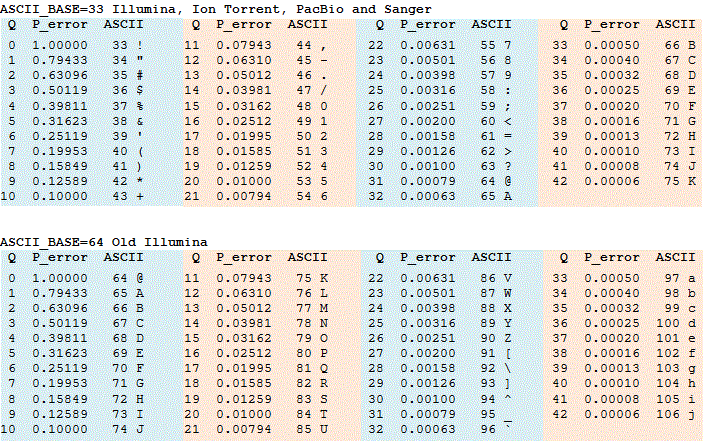



## Example:
- ASCII character is `K`
- ASCII code is `75`
- Q is 106-ASCII_BASE, i.e. 106-33 = 42
- P_error = $P = 10^{-Q/10}$, i.e. $10^{-42/10}$ = 0.00006

Python functions for encoding and decoding ASCII

> `ord(c, /)`
>
> Return the Unicode/ASCII code point for a one-character string.
>
> ```chr(i, /)```
>
> Return a Unicode/ASCII string of one character with ordinal i;

In [ ]:
ord('!'), ord('K')

(33, 75)

In [ ]:
chr(33), chr(75)

('!', 'K')

In [ ]:
#| export
def p_error_from_q_score_char(
    char:str,             # ASCII character retrieved from Q Score or Phred value in FASTQ
    ASCII_base:int=33     # ASCII base. Mostly 33, can be 64 in old FASTQ files
):
    """Returns P_error from the Q_Score ASCII Character."""
    ASCII_code = ord(char)
    Q = ASCII_code - ASCII_base
    p_error = 10**(-Q/10)
    return p_error

In [ ]:
ASCII_Q_scores = ''.join([chr(i) for i in range(75, 32, -1)])
print('Possible values for Q Scores and corresponding P error:')
print(f"    ASCII Q Score | Q Score | P error")
print(f"    {'-'*14}|{'-'*9}|{'-'*8}")
print('\n'.join([f"    {char:^14}|{ord(char)-33:^9}| {p_error_from_q_score_char(char):6.5f} " for char in ASCII_Q_scores]))

Possible values for Q Scores and corresponding P error:
    ASCII Q Score | Q Score | P error
    --------------|---------|--------
          K       |   42    | 0.00006 
          J       |   41    | 0.00008 
          I       |   40    | 0.00010 
          H       |   39    | 0.00013 
          G       |   38    | 0.00016 
          F       |   37    | 0.00020 
          E       |   36    | 0.00025 
          D       |   35    | 0.00032 
          C       |   34    | 0.00040 
          B       |   33    | 0.00050 
          A       |   32    | 0.00063 
          @       |   31    | 0.00079 
          ?       |   30    | 0.00100 
          >       |   29    | 0.00126 
          =       |   28    | 0.00158 
          <       |   27    | 0.00200 
          ;       |   26    | 0.00251 
          :       |   25    | 0.00316 
          9       |   24    | 0.00398 
          8       |   23    | 0.00501 
          7       |   22    | 0.00631 
          6       |   21    | 0.00794 
          

In the case of the FASTQ file showed as example above, the first read is:

```ascii
@2591237:ncbi:1-60400
ACAACTCCTATTCGTAGTTGAAGTTGTTGACAAATACTTTGATTGTTACG
+
CCCBCGFGBGGGGGGGBGGGGGGGGG>GGG1G=/GGGGGGGGGGGGGGGG
```

The following can be parsed:
- The definition line starts with `@`
    - `SeqID`: `2591237`
    - `source`: nbci`
    - `seq_nbr`: `1`
    - `read_nbr`: `60400
- The read sequence: `ACAACTCCTATTCGTAGTTGAAGTTGTTGACAAATACTTTGATTGTTACG`
- The separation between read sequence and Q Score, `+`
- The Q Score in ASCII, e.g. `CCCBCGFGBGGGGGGGBGGGGGGGGG>GGG1G=/GGGGGGGGGGGGGGGG`

This ASCII encoded Q Score can be converted into probability of error for each bp in the read:

In [ ]:
q_scores = 'CCCBCGFGBGGGGGGGBGGGGGGGGG>GGG1G=/GGGGGGGGGGGGGGGG'
print('; '.join([f"{p_error_from_q_score_char(char):6.5f}" for char in q_scores]))

0.00040; 0.00040; 0.00040; 0.00050; 0.00040; 0.00016; 0.00020; 0.00016; 0.00050; 0.00016; 0.00016; 0.00016; 0.00016; 0.00016; 0.00016; 0.00016; 0.00050; 0.00016; 0.00016; 0.00016; 0.00016; 0.00016; 0.00016; 0.00016; 0.00016; 0.00016; 0.00126; 0.00016; 0.00016; 0.00016; 0.02512; 0.00016; 0.00158; 0.03981; 0.00016; 0.00016; 0.00016; 0.00016; 0.00016; 0.00016; 0.00016; 0.00016; 0.00016; 0.00016; 0.00016; 0.00016; 0.00016; 0.00016; 0.00016; 0.00016


It shows that most bp have a very low probability of error, except a few bp with probability or 2.5% and 3.9%, 

# Parsing sequence files

## parsing fasta file

In [ ]:
p2fasta = Path('data_dev/cov_virus_sequences_two.fa').resolve()
print(p2fasta.absolute())
assert p2fasta.is_file()

/home/vtec/projects/bio/metagentools/nbs-dev/data_dev/cov_virus_sequences_two.fa


Split Definition Lines and Sequence Lines

In [ ]:
with open(p2fasta, 'r') as fp:
    dfn_lines = []
    sequences = []
    while True:
        line = fp.readline()
        if line == '': break
        if line[0] == '>':
            dfn_lines.append(line)
        if line[0] in 'ACGT':
            sequences.append(line)
print('Definition line for each sequence:')
print(''.join(dfn_lines))
print('Sequence line for each sequence:')
print(''.join([f"{line[:110]} ... \n" for line in sequences]))

Definition line for each sequence:
>2591237:ncbi:1 [MK211378]	2591237	ncbi	1 [MK211378] 2591237	Coronavirus BtRs-BetaCoV/YN2018D		scientific name
>11128:ncbi:2 [LC494191]

Sequence line for each sequence:
TATTAGGTTTTCTACCTACCCAGGAAAAGCCAACCAACCTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTAGCTGTCGCTCGGCTGCATGCCTA ... 
CATCCCGCTTCACTGATCTCTTGTTAGATCTTTTCATAATCTAAACTTTATAAAAACATCCACTCCCTGTAGTCTATGCCTATGGGCGTAGATTTTTCATAGTGGTGTCT ... 



In [ ]:
fasta_definition_line_pattern = r"^>(?P<seqid>\d+):(?P<source>ncbi):(?P<seq_nbr>\d*)(\s*|\t*)\[(?P<accession>\w*\d*)\](\s*\n|((\s*|\t)(?P=seqid))(\s*|\t)(?P=source)(\s*|\t)\d*(\s*|\t)\[(?P=accession)\](\s*|\t)(?P=seqid)(\s*|\t)(?P<species>.*)(\s*|\t)scientific name\s*\n)"

In [ ]:
seq_metadata = {}
for i, line in enumerate(dfn_lines):      
    matches = re.match(fasta_definition_line_pattern, line)
    metadata = {}
    if matches is not None:
        for g in 'seqid accession seq_nbr species'.split(' '):
            m = matches.group(g)
            metadata[g] = m.replace('\t', ' ').strip() if m is not None else None
        seq_metadata[metadata['accession']] = metadata
        print(metadata)
    else:
        # no match was found for this line, print the definition line for evaluation
        print(i, line)


{'seqid': '2591237', 'accession': 'MK211378', 'seq_nbr': '1', 'species': 'Coronavirus BtRs-BetaCoV/YN2018D'}
{'seqid': '11128', 'accession': 'LC494191', 'seq_nbr': '2', 'species': None}


In [ ]:
#| export
def parse_fasta_definition_line(
    line:str,                   # Definition line in covid sequence fasta file
    pattern:str|None = None,    # Optional regex pattern for definition lines when format is not our standard
):
    """Parse a corona virus sequence fasta file definition line into a metadata dictionary"""
    if pattern is None:
        pattern = r"^>(?P<seqid>\d+):(?P<source>ncbi):(?P<seq_nbr>\d*)(\s*|\t*)\[(?P<accession>\w*\d*)\](\s*\n|((\s*|\t)(?P=seqid))(\s*|\t)(?P=source)(\s*|\t)\d*(\s*|\t)\[(?P=accession)\](\s*|\t)(?P=seqid)(\s*|\t)(?P<species>.*)(\s*|\t)scientific name\s*\n)"
    matches = re.match(pattern, line)
    metadata = {}
    if matches is not None:
        for g in 'seqid accession seq_nbr species'.split(' '):
            m = matches.group(g)
            metadata[g] = m.replace('\t', ' ').strip() if m is not None else None
        return metadata
    else:
        raise ValueError(f"No match on this line")

In [ ]:
for line in dfn_lines:
    print(parse_fasta_definition_line(line))

{'seqid': '2591237', 'accession': 'MK211378', 'seq_nbr': '1', 'species': 'Coronavirus BtRs-BetaCoV/YN2018D'}
{'seqid': '11128', 'accession': 'LC494191', 'seq_nbr': '2', 'species': None}


In [ ]:
#| export
def parse_sequence_fasta(
    path: str|Path,                 # path to the fasta sequence file
    return_metadata: bool = False   # return the metadata dictionary if True
):
    """Parse metadata for each sequence in sequence file and save a json file"""
    # validate path
    if isinstance(path, str): path = Path(path)
    if not path.is_file(): raise ValueError(f"Cannot find a file at {path.absolute}. Check the path")
    
    with open(path, 'r') as fp:
        dfn_lines = []
        sequences = []
        while True:
            line = fp.readline()
            if line == '': break
            if line[0] == '>':
                dfn_lines.append(line)
            if line[0] in 'ACGT':
                sequences.append(line)
    seqs_metadata = {}
    for line in dfn_lines:
        metadata = parse_fasta_definition_line(line)
        seqs_metadata[metadata['seqid']] = metadata

    p2json = path.parent / f"{path.stem}_metadata.json"
    with open(p2json, 'w') as fp:
        json.dump(seqs_metadata, fp, indent=4)
    print(f"Metadata for '{path.name}'> saved as \n{p2json.absolute()}")

    
    if return_metadata: return seqs_metadata

In [ ]:
p2fasta = Path('data_dev/cov_virus_sequence_one.fa').resolve()
assert p2fasta.is_file()

parse_sequence_fasta(p2fasta)

Metadata for 'cov_virus_sequence_one.fa'> saved as 
/home/vtec/projects/bio/metagentools/nbs-dev/data_dev/cov_virus_sequence_one_metadata.json


In [ ]:
p2fasta = Path('data_dev/cov_virus_sequences_two.fa').resolve()
assert p2fasta.is_file()

parse_sequence_fasta(p2fasta)

Metadata for 'cov_virus_sequences_two.fa'> saved as 
/home/vtec/projects/bio/metagentools/nbs-dev/data_dev/cov_virus_sequences_two_metadata.json


In [ ]:
#| hide
nbdev.nbdev_export()